In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Activation, Layer, Dense
from keras.models import Model
from scipy.spatial import distance
from packages.Utility.SVM.SVM import *
from packages.Utility.SVM.Kernel import *
from packages.Utility.CNN.Callbacks import SaveModel
from packages.Utility.DatasetManager import DatasetReader
from packages.Utility.Metrics import plot_conf_matrix
from packages.Utility.Gabor import GaborFilterBanks, GaborParams, RotatedGaborParams

Using TensorFlow backend.


# Memuat Dataset

In [2]:
reader = DatasetReader('dataset/bin/digit 32x32 50k')
fold = 0

X_train, Y_train_onehot, Y_train_single = reader.getTrainData(fold)
X_test, Y_test_onehot, Y_test_single = reader.getTestData(fold)

# Pra-Training

In [3]:
save_model = SaveModel(base_dir = 'trained/digit 32x32 50k LN1', X_val = X_train, Y_val = Y_train_onehot)

# Mendefinisikan Model CNN
Mendefinisikan arsitektur CNN

In [4]:
model = Sequential()

c1 = Conv2D(name='c1', filters = 6, kernel_initializer = GaborFilterBanks(RotatedGaborParams(lambd = 0.5, psi = 1.57, sigma = 2, gamma = 0.75)),
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu', 
            input_shape = (32, 32, 1))
c2 = Conv2D(name='c2', filters = 16, kernel_initializer = GaborFilterBanks(RotatedGaborParams(lambd = 0.5, psi = 1.57, sigma = 2, gamma = 0.75)), 
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu')
m1 = MaxPool2D(pool_size = 2)
m2 = MaxPool2D(pool_size = 2)
f1 = Flatten(name = 'flatten')
model.add(c1)
model.add(m1)
model.add(c2)
model.add(m2)
model.add(f1)
model.add(Dense(10, activation = 'softmax', name = 'd3'))

# Melakukan Pelatihan
Melakukan pelatihan pada CNN

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, Y_train_onehot, epochs = 1, verbose = 1, batch_size = 128, callbacks=[save_model])

Epoch 1/1
33750/33750 [==============================] - 613s 18ms/step - loss: 0.1668 - acc: 0.1657
val_acc: 0.146


## Menghitung Akurasi CNN
### Akurasi data training

Confusion matrix, without normalization
[[   0    0    0   11    0  116    3 3620    0]
 [   0    0    0 3561    0    0    0  189    0]
 [   0    0    0 1395    0    1    4 2350    0]
 [   0    1    0 1283    0  147    0 2319    0]
 [   0    1    0  347    0   39    0 3363    0]
 [   0    0    0  316    0  385    2 3047    0]
 [   0    0    0  176    0   73    1 3500    0]
 [   0    0    0  461    0   27    0 3262    0]
 [   0    0    0  575    0   73    0 3102    0]]


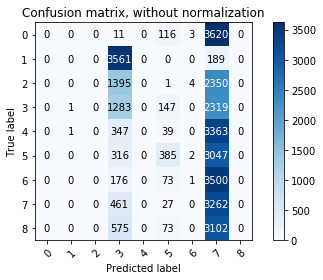

In [6]:
predicted = model.predict(X_train)
y_pred = np.argmax(predicted, axis = 1)
y_true = Y_train_single

plot_conf_matrix(y_true, y_pred, reader.labels, figsize = (7, 7))

### Akurasi data testing

In [ ]:
predicted = model.predict(X_test)
y_pred = np.argmax(predicted, axis = 1)
y_true = Y_test_single

plot_conf_matrix(y_true, y_pred, reader.labels, figsize = (7, 7))

# Melakukan Pelatihan dengan SVM
data dari Flatten layer dilatih pada SVM dan
diuji akurasinya

In [7]:
feature_model = Model(
    inputs = model.input,
    outputs = model.get_layer('flatten').output
)

features_train = feature_model.predict(X_train)

cls = svm.SVC(kernel = 'linear', max_iter = 50000, C = 100, decision_function_shape='ovo', verbose = True)
cls.fit(features_train, Y_train_single)
# joblib.dump(cls, 'trained/trained_svm_digit.sav')

[LibSVM]

c:\python\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=50000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

## Akurasi SVM
### Data Training

Confusion matrix, without normalization
[[3750    0    0    0    0    0    0    0    0]
 [   0 3750    0    0    0    0    0    0    0]
 [   0    0 3750    0    0    0    0    0    0]
 [   0    0    0 3738    0   12    0    0    0]
 [   0    0    0    0 3750    0    0    0    0]
 [   0    0    0    7    0 3743    0    0    0]
 [   0    0    0    0    0    0 3750    0    0]
 [   0    0    0    0    0    0    0 3750    0]
 [   0    0    0    0    0    0    0    0 3750]]


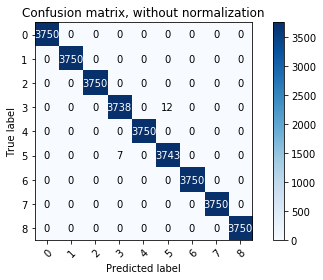

In [8]:
# cls = joblib.load('trained/trained_svm_digit.sav')
y_pred = cls.predict(features_train)
y_true = Y_train_single

plot_conf_matrix(y_true, y_pred, dsreader.labels)

### Data Testing

In [ ]:
features_test = feature_model.predict(X_test)

Confusion matrix, without normalization
[[1228    0    3    1    0    2    4    2   10]
 [   0 1231    7    2    0    0    0    6    4]
 [  10    7 1188   15    2    0    1   11   16]
 [   3    1   22 1189    2   18    0    7    8]
 [   3    3   10    3 1199    0    3   21    8]
 [   9    3    7   34    4 1173    5    2   13]
 [  12    3    4    3    1   12 1214    0    1]
 [   1   11    7    4   19    6    0 1200    2]
 [  15   16   18   16   10   22    3    5 1145]]


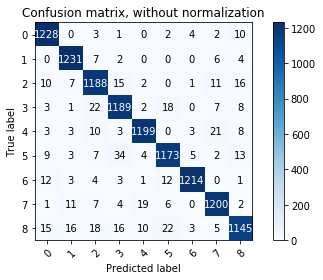

In [10]:
y_pred = cls.predict(features_test)
y_true = Y_test_single

plot_conf_matrix(y_true, y_pred, dsreader.labels)

# Retrieval Dengan SVM sebagai klasifikasi

Kueri acak

In [ ]:
index_kueri = np.random.randint(X_test.shape[0])
kueri = X_test[index_kueri]

### Mendapatkan fitur dari data training

In [ ]:
train_feature = feature_model.predict(X_train)

## Menggabungkan dengan dataset training

In [ ]:
collection = np.append(dataset[fold[0, 0]], train_feature, axis = 1)

### Klasifikasi kueri

In [ ]:
# cls = joblib.load('trained/trained_svm_digit.sav')
ftr = feature_model.predict(np.array([kueri]))
pred = cls.predict(ftr)

### Mendapatkan daftar citra sesuai hasil klasifikasi

In [ ]:
box = collection[np.where(collection[:, 1] == pred[0])]

### Menghitung jarak

In [ ]:
jarak = []

for i in range(box.shape[0]):
    jarak.append([box[i, 3], distance.euclidean(box[i, 4:], ftr)])
    
jarak.sort(key = lambda x: x[1])    

### Menampilkan hasil

In [ ]:
print('Kelas kueri : ', dataset[fold[0, 1]][index_kueri, 1])
print('Prediksi : ', pred[0])

fig = plt.figure(figsize = (20, 20))

## menampilkn query
y = fig.add_subplot(5, 5, 1)
y.imshow(
    cv.cvtColor(cv.imread(dataset[fold[0, 1]][index_kueri, 3]), cv.COLOR_BGR2RGB)
)
plt.title('Kueri')
y.axes.get_xaxis().set_visible(False)
y.axes.get_yaxis().set_visible(False)
    
for i in range(1, 20):
    y = fig.add_subplot(5, 5, i + 1)
    y.imshow(cv.cvtColor(cv.imread(jarak[i][0]), cv.COLOR_BGR2RGB))
    plt.title('Jarak : ' + str(jarak[i][1]))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)